In [143]:
from docxtpl import DocxTemplate, InlineImage
from docx.shared import Mm
import pandas as pd
import numpy as np
import openpyxl
from datetime import datetime, date
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
from epiweeks import Week, Year
import seaborn as sns
import os
import statistics


# Lê os arquivos

In [144]:
# Lê a base de gripe
df_gripe = pd.read_excel('gripe.xlsx')

# Lê o arquivo docx modelo
doc = DocxTemplate('boletim.docx')

# Altera as colunas de data para o tipo data

In [145]:
# Cria uma lista com o nome de todas as colunas com "DT" (significa coluna de data)
datas = []
for x in df_gripe.columns:
    if 'DT' in x:
        datas.append(x)
        
# Altera as colunas de data para o tipo data
df_gripe[datas] = df_gripe[datas].apply(pd.to_datetime,infer_datetime_format = '%d/%m/%Y')

# Cria as variáveis de data

In [146]:
lista_anos = []

x = 0
while x < 1:
    # define a data do primeiro dia da primeira semana epidemológica do ano vigente
    start_date = str(Year(datetime.today().year+x).startdate())

    # define a data do último dia da última semana epidemológica do ano vigente
    end_date = str(Year(datetime.today().year+x).enddate())

    # Cria uma lista vazia
    lista_inicio_fim = []

    # Coloca na primeira posição da lista o ano vigente
    lista_inicio_fim.append(datetime.today().year+x)

    # Coloca na segunda posição da lista a primeira data do início das semanas epidemológicas
    lista_inicio_fim.append(start_date)

    # Coloca na segunda posição da lista a primeira data do Fim das semanas epidemológicas
    lista_inicio_fim.append(end_date)

    lista_anos.append(lista_inicio_fim)

    x +=1


# Cria uma planilha com ano, Data de início e fim das semanas epidemiológicas de cada ano
df_anos = pd.DataFrame(lista_anos, columns = ['ANO', 'INICIO', 'FIM'])

# Transforma as colunas de data no tipo data
df_anos[['INICIO', 'FIM']] = df_anos[['INICIO', 'FIM']].apply(pd.to_datetime,infer_datetime_format = True, errors='coerce')

# Transforma a colunaANO em index
df_anos.set_index('ANO', inplace = True)

# Cria uma variável dia_inicial que recebe o primeiro dia da semana epidemologica do ano atual 
dia_inicial = df_anos['INICIO'][datetime.now().year]

# Cria uma lista com as colunas de datas
datas = ['INICIO','FIM']

# Converte as colunas de data para o formato brasileiro
for data in datas:
    df_anos[data] = df_anos[data].dt.strftime('%d/%m/%Y')



# Cria um dicionário para os meses
meses = {
1:'Janeiro',
2:'Fevereiro',
3:'Março',
4:'Abril',
5:'Maio',
6:'Junho',
7:'Julho',
8:'Agosto',
9:'Setembro',
10:'Outubro',
11:'Novembro',
12:'Dezembro'
}


# Cria a coluna IDADE_REGISTRO subtraindo a data do dia de registro no sistema pela data de nascimento, converte para ano e arredonda para nenhuma casa decimal
df_gripe['IDADE_REGISTRO'] = ((df_gripe['DT_DIGITA'] - df_gripe['DT_NASC'])/ np.timedelta64(1, 'Y')).round()

## Cria a variável de data atual no formato brasileiro

In [147]:
ano = str(date.today().year)
mes = str(date.today().month)
dia_atual = str(date.today().day)

data_atual = dia_atual
data_atual = data_atual+'/'
data_atual = data_atual+mes
data_atual = data_atual+'/'
data_atual = data_atual+ano

# Define a variável ano_atual
ano_atual = date.today().year

antes_ano_atual = ano_atual - 1

# Determnina qual a semana epidemiológica da data atual e aloca na variável semana_ep_atual
semana_ep_atual = Week.fromdate(date(datetime.now().year, datetime.now().month, datetime.now().day)).week

# Define a variável mes_atual
mes_atual = meses[date.today().month]

# Defina a data da primeira semana epidemiológica do ano e aloca na variável primeira_data_semana_ep_atual
primeira_data_semana_ep_atual = df_anos.iloc[0][0]

# Define a quantidade de coletas (quantidade de registros) e aloca na variável qtd_coletas
qtd_coletas = df_gripe.shape[0]

# Encontra o maior dia (o mais recente) na coluna DT_PREENC, converte para o formato padrão BR e aloca na variável ultimo_dia_de_registro
ultimo_dia_de_registro = datetime.strptime(str(df_gripe['DT_PREENC'].max().date()), '%Y-%m-%d').strftime('%d/%m/%y')

dic_datas = {
    'data_atual' : data_atual,
    'ano_atual' : ano_atual,
    'dia_atual' : dia_atual,
    'antes_ano_atual' : antes_ano_atual,
    'semana_ep_atual' : semana_ep_atual,
    'mes_atual' : mes_atual,
    'primeira_data_semana_ep_atual' : primeira_data_semana_ep_atual,
    'qtd_coletas' : qtd_coletas,
    'ultimo_dia_de_registro' : ultimo_dia_de_registro
}

In [148]:
# Determina quantos casos possuem covid
qtd_covid = df_gripe.loc[df_gripe['PCR_SARS2'] ==1].shape[0]

# Define quantas coletas positivas para virus respiratórios
qtd_vi_resp = df_gripe.loc[(df_gripe['PCR_SARS2'] ==1) | (df_gripe['CLASSI_FIN'] == 2) | (df_gripe['CLASSI_FIN'] == 1)].shape[0]

# Define porcentagem de coletas positivas para virus respiratórios
porc_vi_resp = round(qtd_vi_resp * 100 / qtd_coletas, 2)

# Porcentagem de Covid nas pessoas com gripe
porcentagem_covid = round(((qtd_covid * 100)/qtd_vi_resp),1)

# Quantidade de outros virus 
outros_virus = qtd_vi_resp - qtd_covid

# Define a porcentagem de outros vírus
porcentagem_outros_virus = round((outros_virus * 100)/qtd_vi_resp, 1)

# Define quantas coletas negativas para virus respiratórios
qtd_nao_vi_resp = df_gripe.loc[df_gripe['CLASSI_FIN'] == 3].shape[0] + df_gripe.loc[df_gripe['CLASSI_FIN'] == 4].shape[0]

# Define a porcentagem de virus não respiratórios
porc_n_vi_resp = round(qtd_nao_vi_resp*100/qtd_coletas,1)

# Define a quantidade de resultados inconclusivos para covid
inconc = df_gripe.loc[df_gripe['PCR_RESUL'] ==3 ].shape[0]

# Define a porcentagem de cassos inconclusivos para covid
porc_inconc = round(df_gripe.loc[df_gripe['PCR_RESUL'] ==3 ].shape[0] *100 / qtd_coletas,1)

# Define a quantidade de casos aguardando encerramento
ag_enc = df_gripe.loc[df_gripe['PCR_RESUL'].isna()].shape[0]

# Define a porcentagem de casos aguardando encerramento
porc_ag_enc =  round(df_gripe.loc[df_gripe['PCR_RESUL'] ==3 ].shape[0] *100 / qtd_coletas,1)


gripe_covid = {
    'qtd_covid': qtd_covid,
    'qtd_vi_resp': qtd_vi_resp,
    'porc_vi_resp': porc_vi_resp,
    'porcentagem_covid': porcentagem_covid,
    'outros_virus': outros_virus,
    'porcentagem_outros_virus': porcentagem_outros_virus,
    'qtd_nao_vi_resp': qtd_nao_vi_resp,
    'porc_n_vi_resp': porc_n_vi_resp,
    'inconc': inconc,
    'porc_inconc': porc_inconc,
    'ag_enc': ag_enc,
    'porc_ag_enc': porc_ag_enc
}



# Criação do Gráfico 1

### Agrupar casos por semana e Classifin

In [149]:
# Cria a coluna da semana epidemiológica de cada dia
df_gripe['SEMANA'] = 0
for x in df_gripe['DT_PREENC']:
    df_gripe.loc[df_gripe['DT_PREENC'] == x, 'SEMANA'] = Week.fromdate(date(x.year, x.month, x.day)).week

# Cria o df_gripe_agrupado com os valores agrupados por semana e classifin
df_gripe_agrupado = df_gripe.groupby(['SEMANA', 'CLASSI_FIN']).size()

# Reseta o index de df_gripe_agrupado
df_gripe_agrupado = df_gripe_agrupado.reset_index()

# Troca o nome da nova coluna para 'QUANTIDADE'
df_gripe_agrupado = df_gripe_agrupado.rename(columns={0: 'QUANTIDADE'})

# retira o ponto flutuante da coluna CLASSI_FIN
for x in df_gripe_agrupado['CLASSI_FIN'].unique():
    df_gripe_agrupado.loc[df_gripe_agrupado['CLASSI_FIN']==x,'CLASSI_FIN'] = str(int(x))

### Criação da figura do gráfico e definindo o tamanho dele

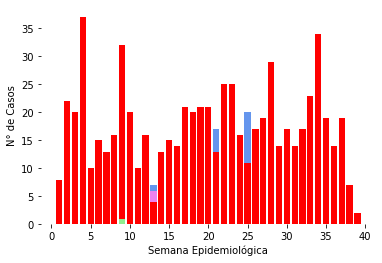

In [150]:
# Link com cores em hexadecimal - https://celke.com.br/artigo/tabela-de-cores-html-nome-hexadecimal-rgb
# Cria um dicionário para cada valor e suas cores em hexadecimal 
cor = {'1' : '#90EE90',
       '2' : '#6495ED',
       '3' : '#EE82EE',
       '4' : '#FF0000'
       }

################################################
# Defini que a imagem não terá linhas laterais##
fig, ax = plt.subplots()                      ##          
ax.spines['top'].set_visible(False)           ##
ax.spines['right'].set_visible(False)         ##
ax.spines['bottom'].set_visible(False)        ##
ax.spines['left'].set_visible(False)          ##
################################################

# Irá definir a cor de cada Classificação final no gráfico
#  Percorre os valores únicos na coluna CLASSI_FIN
for x in df_gripe_agrupado['CLASSI_FIN'].unique():

    # dff recebe todos os registros com CLASSI_FIN = x (no loop)
    dff = df_gripe_agrupado.loc[df_gripe_agrupado['CLASSI_FIN']==x]

    # Define a variável da coluna Y
    semana = dff['SEMANA']

    # Define a variável da coluna X
    quantidade = dff['QUANTIDADE']

    # Define a cor da coluna para o número da CLASSI_FIN atual (percorrida pelo loop), de acordo com o dicionário
    color = cor[df_gripe_agrupado.loc[df_gripe_agrupado['CLASSI_FIN']==x]['CLASSI_FIN'].unique()[0]]

    # Cria o gráfico com X,Y e a cor da CLASSI_FIN atual
    plt.bar(semana,quantidade, color=color)
    
# Define o texto do eixo X
plt.xlabel('Semana Epidemiológica')

# Define o texto do eixo Y
plt.ylabel('N° de Casos')

# Salva a figura na pasta, com o nome grafico_1.png
plt.savefig("graficos/grafico_1.png")

# Define o tamanho da imagem no documento
grafico_1 = InlineImage(doc, os.path.join( "graficos/grafico_1.png"),width=Mm(180), height=Mm(65))
#grafico_1 = InlineImage(doc, os.path.join( "grafico_1.png"),height=Mm(65))

# Exibe o gráfico aqui no código
plt.show()

# Tabela 1

In [151]:
df_gripe['NOME_UNIDADE'] = df_gripe['COD_UNID']

unidade = {
    6216021 :'UBS 5 de Planaltina (HRP)',
    10634 :'UBS 1 do Paranoá (HRL)',
    9480587 :'UBS 12 de Samambaia (HRSAM)',
    2617293 :'UBS 12 Ceilândia (HRC)',
    10723 :'UBS 02 Asa Norte (HRAN)',
    10782 :'UBS 01 de Santa Maria (HRG)',
    3048551 :'Hospital Brasília',
    7111924 :'UPA do Núcleo Bandeirante',
}

# imputa os valores do dicionário unidade na coluna NOME_UNIDADE
df_gripe.replace({'NOME_UNIDADE': unidade}, inplace = True)






cont = 1

us = 'us'
cr = 'cr'
cp = 'cp'
i = 'i'

lista_unidades = []
lista_cod_unidades = []

lista_cod_cr = []
lista_cr = []

lista_cod_cp = []
lista_cp = []

lista_cod_ind = []
lista_ind = []

coletas_prec = semana_ep_atual * 5

for x in df_gripe.NOME_UNIDADE.unique():
    qtd = (df_gripe.loc[df_gripe['NOME_UNIDADE']==x]).shape[0]


    # Cria lista de código para cada unidade
    lista_cod_unidades.append(us+str(cont))
    # CRIA LISTA COM OS NOMES DAS UNIDADES
    lista_unidades.append(x)


    # Cria lista de código para Coletas realizadas por unidade
    lista_cod_cr.append(cr+str(cont))
    # CRIA LISTA COM OS valores das Coletas realizadas por unidade
    lista_cr.append(qtd)

    # Cria lista de código para Coletas Preconizadas por unidade
    lista_cod_cp.append(cp+str(cont))
    # CRIA LISTA COM OS valores das Coletas Preconizadas por unidade
    lista_cp.append(coletas_prec)

    # Cria lista de código para indicador por unidade
    lista_cod_ind.append(i+str(cont))
    # CRIA LISTA COM OS valores dasporcentagens por unidade
    lista_ind.append(round(qtd * 100 / coletas_prec, 1))
    
    cont +=1



# Cria dicionários com os códigos e valores da tabela 1
unidades = zip(lista_cod_unidades, lista_unidades)
unidades = dict(unidades)

cr = zip(lista_cod_cr, lista_cr)
cr = dict(cr)

cp = zip(lista_cod_cp, lista_cp)
cp = dict(cp)

ind = zip(lista_cod_ind, lista_ind)
ind = dict(ind)




# Cria o total de coletas realizadas
tot_cr = sum(lista_cr)

# Cria o total de coletas preconizadas
tot_cp = sum(lista_cp)

# Cria a porcentagem total de coletas realizadas por preconizadas
tot_i = round(tot_cr * 100 / tot_cp,1)

total = {'cr9' : tot_cr, 'cp9' : tot_cp, 'i9' : tot_i}


# Junta os dicionários
tab1 = {**unidades, **cr, **cp, **ind, **total}

# SRAG

In [152]:
# Lê  a base de srag
df = pd.read_excel('Planilha para Boletim.xlsx')

df.to_csv('df_csv.csv', index = False, encoding='utf-8-sig')


df = pd.read_csv('df_csv.csv', parse_dates=[0], dayfirst=True)

# Alterar as colunas de Datas para o tipo data
# Cria uma lista com o nome de todas as colunas que possuem 'DT'
datas = []
for x in df.columns:
    if 'DT' in x:
        datas.append(x)

# Altera todas as colunas de data persente na lista de datas para o tipo date
df[datas] = df[datas].apply(pd.to_datetime, format='%d/%m/%Y', errors='coerce')

df = df.loc[(pd.DatetimeIndex(df['DT_SIN_PRI']).year == ano_atual - 1) | (pd.DatetimeIndex(df['DT_SIN_PRI']).year == ano_atual)]




# Cria a coluna FAIXA_ETARIA e aloca zero em todos os registros
df['FAIXA_ETARIA'] = 0

df.loc[df['IDADE_REGISTRO']<2, 'FAIXA_ETARIA'] = 'Menor de 2'

df.loc[(df['IDADE_REGISTRO']>=2.0) & (df['IDADE_REGISTRO'] <=10.0), 'FAIXA_ETARIA'] = '2 a 10'

df.loc[(df['IDADE_REGISTRO']>=11.0) & (df['IDADE_REGISTRO'] <=19.0), 'FAIXA_ETARIA'] = '11 a 19'

df.loc[(df['IDADE_REGISTRO']>=20.0) & (df['IDADE_REGISTRO'] <=29.0), 'FAIXA_ETARIA'] = '20 a 29'

df.loc[(df['IDADE_REGISTRO']>=30.0) & (df['IDADE_REGISTRO'] <=39.0), 'FAIXA_ETARIA'] = '30 a 39'

df.loc[(df['IDADE_REGISTRO']>=40.0) & (df['IDADE_REGISTRO'] <=49.0), 'FAIXA_ETARIA'] = '40 a 49'

df.loc[(df['IDADE_REGISTRO']>=50.0) & (df['IDADE_REGISTRO'] <=59.0), 'FAIXA_ETARIA'] = '50 a 59'

df.loc[(df['IDADE_REGISTRO']>=60.0) & (df['IDADE_REGISTRO'] <=69.0), 'FAIXA_ETARIA'] = '60 a 69'

df.loc[(df['IDADE_REGISTRO']>=70.0) & (df['IDADE_REGISTRO'] <=79.0), 'FAIXA_ETARIA'] = '70 a 79'

df.loc[df['IDADE_REGISTRO']>= 80, 'FAIXA_ETARIA'] = '80 e mais'

## Síntese de casos de SRAG acumulados
## DF

In [153]:
df_df = df.loc[((df['FEBRE'] ==1) | (df['GARGANTA'] ==1) | (df['TOSSE'] ==1) | (df['PERD_OLFT'] ==1) | (df['PERD_PALA'] ==1)) & ((df['DESC_RESP'] ==1) | (df['DISPNEIA'] ==1) | (df['SATURACAO'] ==1))]

df_df = df_df.loc[df_df['SG_UF'] == 'DF']
# Total de casos SRAG 
tot_srag_df = df_df.shape[0]

# Total de casos SRAG ano anterior
tot_srag_ant_df = df_df.loc[pd.DatetimeIndex(df_df['DT_SIN_PRI']).year == ano_atual - 1].shape[0]

# Total de casos SRAG ano atual
tot_srag_atu_df = tot_srag_df - tot_srag_ant_df


# Total de óbitos por SRAG
ob_srag_df = df_df.loc[df_df['EVOLUCAO'] == 2].shape[0]

# Total de obitos por SRAG ano anterior
ob_srag_ant_df =  df_df.loc[(df['EVOLUCAO'] == 2) & (pd.DatetimeIndex(df['DT_SIN_PRI']).year == ano_atual - 1)].shape[0]

# Total de obitos por SRAG ano atual
ob_srag_atu_df = ob_srag_df - ob_srag_ant_df



# Define o total de casos SRAG ocasionados por COVID
tot_srag_cov_df = df_df.loc[df_df['CLASSI_FIN'] == 5].shape[0]
# Define a porcentagem de casos SRAG ocasionados por COVID
porc_srag_cov_df = round(tot_srag_cov_df * 100 / tot_srag_df, 1)


# Define o total de casos SRAG não especificados
srag_n_es_df = df_df.loc[df_df['CLASSI_FIN'] == 4].shape[0]
# Define a porcentagem de casos SRAG não especificados
porc_srag_n_es_df = round(srag_n_es_df * 100 / tot_srag_df, 1)


# Define o total de casos SRAG ocasionados por outro vírus respiratório
srag_out_v_df = df_df.loc[df_df['CLASSI_FIN'] == 2].shape[0]
# Define a porcentagem de casos SRAG ocasionados por outro vírus respiratório
porc_srag_out_v_df = round(srag_out_v_df * 100 / tot_srag_df, 1)


# Define o total de casos SRAG ocasionados por influenza
srag_inf_df = df_df.loc[df_df['CLASSI_FIN'] == 1].shape[0]
# Define a porcentagem de casos SRAG ocasionados por influenza
porc_srag_inf_df = round(srag_inf_df * 100 / tot_srag_df, 1)

srag_df = {
    'tot_srag_df' : tot_srag_df,
    'tot_srag_ant_df' : tot_srag_ant_df,
    'tot_srag_atu_df' : tot_srag_atu_df,
    'ob_srag_df' : ob_srag_df,
    'ob_srag_ant_df' : ob_srag_ant_df,
    'ob_srag_atu_df' : ob_srag_atu_df,
    'tot_srag_cov_df' : tot_srag_cov_df,
    'porc_srag_cov_df' : porc_srag_cov_df,
    'srag_n_es_df' : srag_n_es_df,
    'porc_srag_n_es_df' : porc_srag_n_es_df,
    'srag_out_v_df' : srag_out_v_df,
    'porc_srag_out_v_df' : porc_srag_out_v_df,
    'srag_inf_df' : srag_inf_df,
    'porc_srag_inf_df' : porc_srag_inf_df
}


## Todos Estados

## Gráfico 2

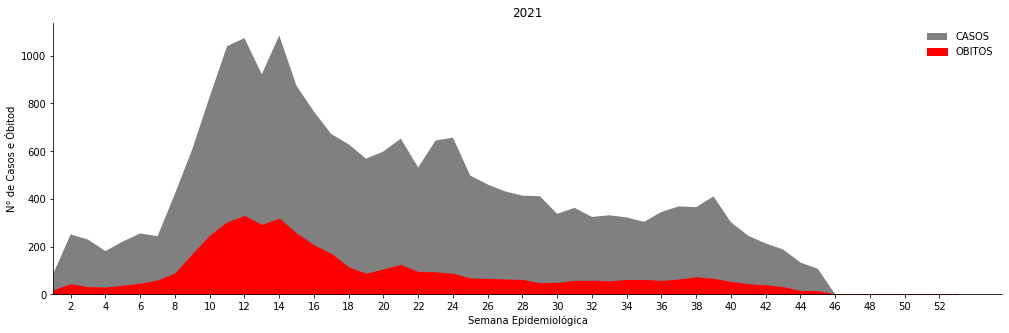

In [154]:
# Cria um df somente com srag
#df = df.loc[((df['FEBRE'] ==1) | (df['GARGANTA'] ==1) | (df['TOSSE'] ==1) | (df['PERD_OLFT'] ==1) | (df['PERD_PALA'] ==1)) & ((df['DESC_RESP'] ==1) | (df['DISPNEIA'] ==1) | (df['SATURACAO'] ==1))]


# Cria uma lista com valores das semanas
lista_semanas = []

# Cria uma lista com curas por semana
lista_casos = []

# Cria uma lista com óbitos por semana
lista_obito= []

# Preenche as lisats
for x in df.SEM_NOT.unique():

    lista_semanas.append(x)

    lista_casos.append(df_df.loc[pd.DatetimeIndex(df_df['DT_SIN_PRI']).year == ano_atual].loc[df_df['SEM_NOT']==x].shape[0])

    lista_obito.append(df_df.loc[pd.DatetimeIndex(df_df['DT_SIN_PRI']).year == ano_atual].loc[df_df['EVOLUCAO']==2].loc[df_df['SEM_NOT']==x].shape[0])

# Cria uma planilha com curas e óbitos por semana
df_casos = pd.DataFrame(list(zip(lista_semanas, lista_casos, lista_obito)),
               columns =['SEMANA', 'CURA', 'OBITO'])

# Orneda df_casos pela semana epidemiológica
df_casos.sort_values('SEMANA', inplace = True)





# Define o tamanho da figura
plt.figure(figsize=(17,5))

# Remo linha externa de cima
plt.rcParams['axes.spines.top'] = False
# Remo linha externa da direita
plt.rcParams['axes.spines.right'] = False

# Define as variáveis do gráfico
plt.fill_between(df_casos['SEMANA'], df_casos['CURA'], 0, facecolor='gray')
plt.fill_between(df_casos['SEMANA'], df_casos['OBITO'], 0, facecolor='red',color='red')

# Define para mostrar todas as semanas pares
plt.xticks(df_casos.loc[df_casos['SEMANA']% 2 == 0]['SEMANA'])

# Define o texto do eixo X
plt.xlabel('Semana Epidemiológica')

# Define o texto do eixo Y
plt.ylabel('N° de Casos e Óbitod')

# Remove as grades do gráfico
plt.grid(False)

# Define a legenda
plt.legend(['CASOS', 'OBITOS'], frameon=False)

# Define o ponto de início no eixo y
plt.ylim(ymin=0) 
# Define o ponto de início no eixo x
plt.xlim(xmin=1) 

plt.title(ano_atual)

# Salva a figura na pasta, com o nome grafico_1.png
plt.savefig("graficos/grafico_2_2.png")

# Define o tamanho da imagem no documento
grafico_2_2 = InlineImage(doc, os.path.join( "graficos/grafico_2_2.png"),width=Mm(200), height=Mm(50))


plt.show()


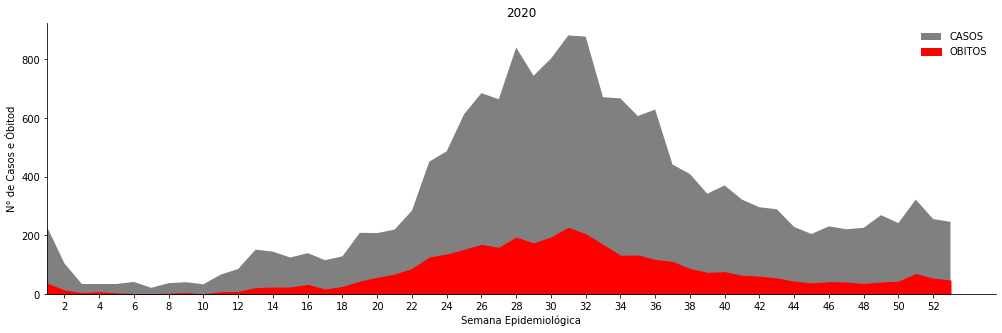

In [155]:
# Cria uma lista com valores das semanas
lista_semanas = []

# Cria uma lista com curas por semana
lista_casos = []

# Cria uma lista com óbitos por semana
lista_obito= []

# Preenche as lisats
for x in df.SEM_NOT.unique():

    lista_semanas.append(x)

    lista_casos.append(df_df.loc[pd.DatetimeIndex(df_df['DT_SIN_PRI']).year == ano_atual - 1].loc[df_df['SEM_NOT']==x].shape[0])

    lista_obito.append(df_df.loc[pd.DatetimeIndex(df_df['DT_SIN_PRI']).year == ano_atual - 1].loc[df_df['EVOLUCAO']==2].loc[df_df['SEM_NOT']==x].shape[0])

# Cria uma planilha com curas e óbitos por semana
df_casos = pd.DataFrame(list(zip(lista_semanas, lista_casos, lista_obito)),
               columns =['SEMANA', 'CURA', 'OBITO'])

# Orneda df_casos pela semana epidemiológica
df_casos.sort_values('SEMANA', inplace = True)






# Define o tamanho da figura
plt.figure(figsize=(17,5))

# Remo linha externa de cima
plt.rcParams['axes.spines.top'] = False
# Remo linha externa da direita
plt.rcParams['axes.spines.right'] = False

# Define as variáveis do gráfico
plt.fill_between(df_casos['SEMANA'], df_casos['CURA'], 0, facecolor='gray')
plt.fill_between(df_casos['SEMANA'], df_casos['OBITO'], 0, facecolor='red',color='red')

# Define para mostrar todas as semanas pares
plt.xticks(df_casos.loc[df_casos['SEMANA']% 2 == 0]['SEMANA'])

# Define o texto do eixo X
plt.xlabel('Semana Epidemiológica')

# Define o texto do eixo Y
plt.ylabel('N° de Casos e Óbitod')

# Remove as grades do gráfico
plt.grid(False)

# Define a legenda
plt.legend(['CASOS', 'OBITOS'], frameon=False)

# Define o ponto de início no eixo y
plt.ylim(ymin=0) 
# Define o ponto de início no eixo x
plt.xlim(xmin=1) 

plt.title(ano_atual - 1)

# Salva a figura na pasta, com o nome grafico_1.png
plt.savefig("graficos/grafico_2_1.png")

# Define o tamanho da imagem no documento
grafico_2_1 = InlineImage(doc, os.path.join( "graficos/grafico_2_1.png"),width=Mm(200), height=Mm(50))


plt.show()


# Figura 3

## Abaixo figura 3

In [156]:
# Cria um df somente com srag
df_srag = df.loc[((df['FEBRE'] ==1) | (df['GARGANTA'] ==1) | (df['TOSSE'] ==1) | (df['PERD_OLFT'] ==1) | (df['PERD_PALA'] ==1)) & ((df['DESC_RESP'] ==1) | (df['DISPNEIA'] ==1) | (df['SATURACAO'] ==1))]

df_srag = df_srag.loc[pd.DatetimeIndex(df_srag['DT_SIN_PRI']).year == ano_atual]

# Determina a quantidade de casos srag
tot_srag = df_srag.shape[0]

# Porcentagem de casos srag df
porc_srag_df = round(tot_srag_atu_df * 100 / tot_srag, 1)


# total de casos srag go
tot_srag_go = df_srag.loc[df_srag['SG_UF'] == 'GO'].shape[0]

# Porcentagem de casos srag go
porc_srag_go = round(tot_srag_go * 100 / tot_srag, 1)



# quantidade srag outras regioes
tot_srag_out = tot_srag - tot_srag_atu_df - tot_srag_go

# pORCENTAGEM de srag outras regioes
porc_srag_out = round(tot_srag_out * 100 / tot_srag, 1)


# Total de obitos srag por covid
ob_srag_cov_df = df_df.loc[(df['EVOLUCAO'] == 2) & (pd.DatetimeIndex(df['DT_SIN_PRI']).year != ano_atual - 1)].loc[df_df['CLASSI_FIN'] == 5].shape[0]

# Porcentagem de obitos srag por covid
porc_ob_srag_cov_df = round(ob_srag_cov_df *100 / ob_srag_atu_df,1)


# Total de obitos srag não especificados
ob_srag_n_es_df = df_df.loc[(df['EVOLUCAO'] == 2) & (pd.DatetimeIndex(df['DT_SIN_PRI']).year != ano_atual - 1)].loc[df_df['CLASSI_FIN'] == 4].shape[0]

# Porcentagem de obitos srag não especificados
porc_ob_srag_n_es_df = round(ob_srag_n_es_df *100 / ob_srag_atu_df,1)


# Total de obitos srag por outros vírus respiratórios
ob_srag_out_vi_df = df_df.loc[(df['EVOLUCAO'] == 2) & (pd.DatetimeIndex(df['DT_SIN_PRI']).year != ano_atual - 1)].loc[df_df['CLASSI_FIN'] == 2].shape[0]

# Porcentagem de obitos srag por outros vírus respiratórios
porc_ob_srag_out_vi_df = round(ob_srag_out_vi_df *100 / ob_srag_atu_df,1)


srag_tot = {
    'tot_srag' : tot_srag,
    'porc_srag_df' : porc_srag_df,
    'tot_srag_go' : tot_srag_go,
    'porc_srag_go' : porc_srag_go,
    'tot_srag_out' : tot_srag_out,
    'porc_srag_out' : porc_srag_out,
    'ob_srag_cov_df' : ob_srag_cov_df,
    'porc_ob_srag_cov_df' : porc_ob_srag_cov_df,
    'ob_srag_n_es_df' : ob_srag_n_es_df,
    'porc_ob_srag_n_es_df' : porc_ob_srag_n_es_df,
    'ob_srag_out_vi_df' : ob_srag_out_vi_df,
    'porc_ob_srag_out_vi_df' : porc_ob_srag_out_vi_df
}

# Tabela 2

In [157]:
# Cria uma planilha com os dados do DF do ano atual
df_df_srag = df_srag.loc[df_srag['SG_UF'] == 'DF']


# Lista de valores de classi_fin
lista_virus = [5, 4, 2, 3, 1]

# Contador
cont = 1

#lista de chaves da coluna n de casos
lst_tab2_c = []
# Lista de valores da coluna n de casos
val_lst_tab2_c = []

#lista de chaves da coluna porcentagem de casos
lst_tab2_cp = []
# Lista de valores da coluna porcentagem de casos
val_lst_tab2_cp = []

#lista de chaves da coluna n de obitos
lst_tab2_o = []
# Lista de valores da coluna n de obitos
val_lst_tab2_o = []

#lista de chaves da coluna porcentagem obitos
lst_tab2_op = []
# Lista de valores da coluna porcentagem obitos
val_lst_tab2_op = []



for x in lista_virus:

    # acrescenta na lista de chaves da coluna n de casos o valor tab2_c acrescido do contador Ex: tab2_c1
    lst_tab2_c.append('tab2_c'+ str(cont))
    # acrescenta na lista de valor da coluna n de casos a quantidade de casos com classi_fim = x 
    val_lst_tab2_c.append(df_df_srag.loc[df['CLASSI_FIN'] == x].shape[0])



    # acrescenta na lista de chaves da coluna porcentagem de casos o valor tab2_cp acrescido do contador Ex: tab2_cp1
    lst_tab2_cp.append('tab2_cp'+ str(cont))
    # acrescenta na lista de valor da coluna porcentagem de casos a porcentagem de casos com classi_fim = x 
    val_lst_tab2_cp.append(round(val_lst_tab2_c[cont-1] * 100 / df_df_srag.shape[0],1)) 



    # acrescenta na lista de chaves da coluna n de obitos o valor tab2_o acrescido do contador Ex: tab2_o1
    lst_tab2_o.append('tab2_o'+ str(cont))
    # acrescenta na lista de valor da coluna n de obitos a quantidade de obitos com classi_fim = x 
    val_lst_tab2_o.append(df_df_srag.loc[(df['CLASSI_FIN'] == x) & (df_df_srag['EVOLUCAO'] == 2)].shape[0])



    # acrescenta na lista de chaves da coluna porcentagem de obitos o valor tab2_op acrescido do contador Ex: tab2_op1
    lst_tab2_op.append('tab2_op'+ str(cont))
    # acrescenta na lista de valor da coluna porcentagem de obitos a porcentagem de obitos com classi_fim = x 
    val_lst_tab2_op.append(round(val_lst_tab2_o[cont-1] * 100 / df_df_srag.loc[df_df_srag['EVOLUCAO'] == 2].shape[0], 1))

    # Acrescenta um valor no contador
    cont +=1




# acrescenta na lista de chaves da coluna n de casos o valor tab2_c6
lst_tab2_c.append('tab2_c6')
# acrescenta na lista de valor da coluna n de casos a quantidade de casos com classi_fim diferente de 1,2,3,4 ou 5 (valores nulos)
val_lst_tab2_c.append(df_df_srag.shape[0] - sum(val_lst_tab2_c))


# acrescenta na lista de chaves da coluna porcentagem de casos o valor tab2_cp6
lst_tab2_cp.append('tab2_cp6')
# acrescenta na lista de valor da coluna porcentagem de casos a porcentagem de casos com classi_fim diferente de 1,2,3,4 ou 5 (valores nulos)
val_lst_tab2_cp.append(round(val_lst_tab2_c[5] * 100 / df_df_srag.shape[0],1)) 


# acrescenta na lista de chaves da coluna n de obitos o valor tab2_o6
lst_tab2_o.append('tab2_o6')
# acrescenta na lista de valor da coluna n de obitos a quantidade de obitos com classi_fim diferente de 1,2,3,4 ou 5 (valores nulos)
val_lst_tab2_o.append(df_df_srag.loc[df_df_srag['EVOLUCAO'] == 2].shape[0] - sum(val_lst_tab2_o) )


# acrescenta na lista de chaves da coluna porcentagem de obitos o valor tab2_op6
lst_tab2_op.append('tab2_op6')
# acrescenta na lista de valor da coluna porcentagem de obitos a porcentagem de obitos com classi_fim diferente de 1,2,3,4 ou 5 (valores nulos)
val_lst_tab2_op.append(round(val_lst_tab2_o[5] * 100 / df_df_srag.loc[df_df_srag['EVOLUCAO'] == 2].shape[0], 1))

ultima_linha = {
    'tab2_ctot' : sum(val_lst_tab2_c),
    'tab2_otot' : sum(val_lst_tab2_o)
}

# cria o cidionário tab2 unindo todos os dicionários formados pelas chaves e valores de cada coluna
tab2 = {**dict(zip(lst_tab2_c, val_lst_tab2_c)), **dict(zip(lst_tab2_cp, val_lst_tab2_cp)), **dict(zip(lst_tab2_o, val_lst_tab2_o)), **dict(zip(lst_tab2_op, val_lst_tab2_op)), **ultima_linha}

# Gráfico 4

## Ano atual

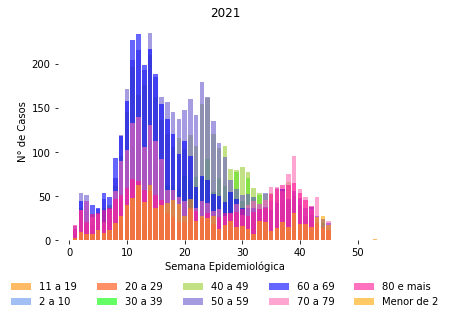

In [158]:
# Cria o gráfico com os dados do ano atual

df_srag_df_agrupado_atual = df_df.loc[pd.DatetimeIndex(df_df['DT_SIN_PRI']).year == ano_atual]


# Cria o df_gripe_agrupado com os valores agrupados por semana e classifin
df_srag_df_agrupado_atual = df_srag_df_agrupado_atual.groupby(['FAIXA_ETARIA', 'SEM_NOT']).size()

# Reseta o index de df_gripe_agrupado
df_srag_df_agrupado_atual = df_srag_df_agrupado_atual.reset_index()

# Troca o nome da nova coluna para 'QUANTIDADE'
df_srag_df_agrupado_atual = df_srag_df_agrupado_atual.rename(columns={0: 'QUANTIDADE'})



# Link com cores em hexadecimal - https://celke.com.br/artigo/tabela-de-cores-html-nome-hexadecimal-rgb
# Cria um dicionário para cada valor e suas cores em hexadecimal 
cor = {'Menor de 2' : '#FFA500',
       '2 a 10' : '#6495ED',
       '11 a 19' : '#FF8C00',
       '20 a 29' : '#FF4500',
       '30 a 39' : '#00FF00',
       '40 a 49' : '#9ACD32',
       '50 a 59' : '#6A5ACD',
       '60 a 69' : '#0000FF',
       '70 a 79' : '#FF69B4',
       '80 e mais' : '#FF1493'
       }

################################################
# Defini que a imagem não terá linhas laterais##
fig, ax = plt.subplots()                      ##          
ax.spines['top'].set_visible(False)           ##
ax.spines['right'].set_visible(False)         ##
ax.spines['bottom'].set_visible(False)        ##
ax.spines['left'].set_visible(False)          ##
################################################

# Irá definir a cor de cada Classificação final no gráfico
#  Percorre os valores únicos na coluna CLASSI_FIN
legenda = []
for x in df_srag_df_agrupado_atual['FAIXA_ETARIA'].unique():

    # dff recebe todos os registros com CLASSI_FIN = x (no loop)
    dff = df_srag_df_agrupado_atual.loc[df_srag_df_agrupado_atual['FAIXA_ETARIA']==x]

    # Define a variável da coluna Y
    semana = dff['SEM_NOT']

    # Define a variável da coluna X
    quantidade = dff['QUANTIDADE']

    # Define a cor da coluna para o número da CLASSI_FIN atual (percorrida pelo loop), de acordo com o dicionário
    color = cor[x]

    legenda.append(x)

    # Cria o gráfico com X,Y e a cor da CLASSI_FIN atual
    plt.bar(semana,quantidade, color=color, alpha=0.6)
    
# Define o texto do eixo X
plt.xlabel('Semana Epidemiológica')

# Define o texto do eixo Y
plt.ylabel('N° de Casos')

plt.title(ano_atual)

ax.legend(legenda, frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)


# Salva a figura na pasta, com o nome grafico_1.png
plt.savefig("graficos/grafico_4_2.png")

# Define o tamanho da imagem no documento
grafico_4_2 = InlineImage(doc, os.path.join( "graficos/grafico_4_2.png"),width=Mm(180), height=Mm(65))


# Exibe o gráfico aqui no código
plt.show()

## Ano anterior

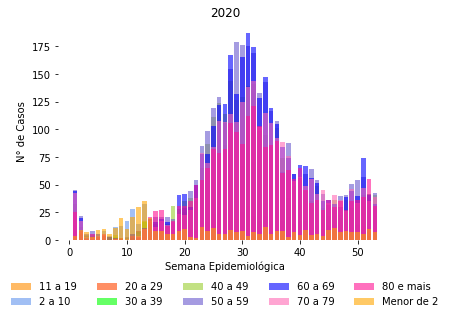

In [159]:
# Cria o gráfico com os dados do ano atual

df_srag_df_agrupado_antes = df_df.loc[pd.DatetimeIndex(df_df['DT_SIN_PRI']).year == ano_atual - 1]


# Cria o df_gripe_agrupado com os valores agrupados por semana e classifin
df_srag_df_agrupado_antes = df_srag_df_agrupado_antes.groupby(['FAIXA_ETARIA', 'SEM_NOT']).size()

# Reseta o index de df_gripe_agrupado
df_srag_df_agrupado_antes = df_srag_df_agrupado_antes.reset_index()

# Troca o nome da nova coluna para 'QUANTIDADE'
df_srag_df_agrupado_antes = df_srag_df_agrupado_antes.rename(columns={0: 'QUANTIDADE'})



# Link com cores em hexadecimal - https://celke.com.br/artigo/tabela-de-cores-html-nome-hexadecimal-rgb
# Cria um dicionário para cada valor e suas cores em hexadecimal 
cor = {'Menor de 2' : '#FFA500',
       '2 a 10' : '#6495ED',
       '11 a 19' : '#FF8C00',
       '20 a 29' : '#FF4500',
       '30 a 39' : '#00FF00',
       '40 a 49' : '#9ACD32',
       '50 a 59' : '#6A5ACD',
       '60 a 69' : '#0000FF',
       '70 a 79' : '#FF69B4',
       '80 e mais' : '#FF1493'
       }

################################################
# Defini que a imagem não terá linhas laterais##
fig, ax = plt.subplots()                      ##          
ax.spines['top'].set_visible(False)           ##
ax.spines['right'].set_visible(False)         ##
ax.spines['bottom'].set_visible(False)        ##
ax.spines['left'].set_visible(False)          ##
################################################

# Irá definir a cor de cada Classificação final no gráfico
#  Percorre os valores únicos na coluna CLASSI_FIN
legenda = []
for x in df_srag_df_agrupado_antes['FAIXA_ETARIA'].unique():

    # dff recebe todos os registros com CLASSI_FIN = x (no loop)
    dff = df_srag_df_agrupado_antes.loc[df_srag_df_agrupado_antes['FAIXA_ETARIA']==x]

    # Define a variável da coluna Y
    semana = dff['SEM_NOT']

    # Define a variável da coluna X
    quantidade = dff['QUANTIDADE']

    # Define a cor da coluna para o número da CLASSI_FIN atual (percorrida pelo loop), de acordo com o dicionário
    color = cor[x]

    legenda.append(x)

    # Cria o gráfico com X,Y e a cor da CLASSI_FIN atual
    plt.bar(semana,quantidade, color=color, alpha=0.6)
    
# Define o texto do eixo X
plt.xlabel('Semana Epidemiológica')

# Define o texto do eixo Y
plt.ylabel('N° de Casos')


plt.title(ano_atual - 1)


ax.legend(legenda, frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5)


# Salva a figura na pasta, com o nome grafico_1.png
plt.savefig("graficos/grafico_4_1.png")


# Define o tamanho da imagem no documento
grafico_4_1 = InlineImage(doc, os.path.join( "graficos/grafico_4_1.png"),width=Mm(180), height=Mm(65))


# Exibe o gráfico aqui no código
plt.show()

# Acima tabela 3

In [160]:
df_vi_re_atual = df.loc[((df['FEBRE'] ==1) | (df['GARGANTA'] ==1) | (df['TOSSE'] ==1) | (df['PERD_OLFT'] ==1) | (df['PERD_PALA'] ==1)) & ((df['DESC_RESP'] ==1) | (df['DISPNEIA'] ==1) | (df['SATURACAO'] ==1))]

# Cria o df de srag do ano atual
df_vi_re_atual = df_vi_re_atual.loc[pd.DatetimeIndex(df_vi_re_atual['DT_SIN_PRI']).year == ano_atual]

# deixa somente os registros com classi_fim 1, 2 ou 5 - vi_resp
df_vi_re_atual = df_vi_re_atual.loc[(df_vi_re_atual['CLASSI_FIN'] == 1) | (df_vi_re_atual['CLASSI_FIN'] == 2) | (df_vi_re_atual['CLASSI_FIN'] == 5)]



# Determina a quantidade de casos srag ocasionados por vírus respiratórios em Sexo Masculino
srag_vi_r_sex_m = df_vi_re_atual.loc[df_vi_re_atual['CS_SEXO'] == 'M'].shape[0]

# Determina a quantidade de óbitos ocasionados por SRAG masculinos
ob_srag_sex_m = df_vi_re_atual.loc[(df_vi_re_atual['EVOLUCAO'] == 2) & (df_vi_re_atual['CS_SEXO'] == 'M')].shape[0]

# Determina a mediana da ideda de homenes que morreram de srag
med_m_ob = str(df_vi_re_atual.loc[(df_vi_re_atual['EVOLUCAO'] == 2) & (df_vi_re_atual['CS_SEXO'] == 'M')]['IDADE_REGISTRO'].median())[0:2]

# Determina a mediana da ideda de homenes que tiveram de srag
med_m_c = str(df_vi_re_atual.loc[(df_vi_re_atual['CLASSI_FIN'] == 1) | (df_vi_re_atual['CLASSI_FIN'] == 2) | (df_vi_re_atual['CLASSI_FIN'] == 5)]['IDADE_REGISTRO'].median())[0:2]

perfil_vi_resp = {
    'srag_vi_r_sex_m' : srag_vi_r_sex_m,
    'ob_srag_sex_m' : ob_srag_sex_m,
    'med_m_ob' : med_m_ob,
    'med_m_c' : med_m_c
}

# Tabela 3

In [161]:
caso_c = []

caso_v = []
porc_caso = []
c_100 = []


obito_v = []
porc_obito = []
o_100 = []

faixa = [ 
'Menor de 2',
'2 a 10',
'11 a 19',
'20 a 29',
'30 a 39',
'40 a 49',
'50 a 59',
'60 a 69',
'70 a 79',
'80 e mais'
 ]

pop = [
87521,
346512,
407141,
506882,
546707,
473776,
337786,
204089,
99777,
42355
]

cont = 0

# Cria os valores de cada coluna da tabela 3 em listas por coluna
for x in faixa:

    caso_c.append(x)

    qtd = df_vi_re_atual.loc[df_vi_re_atual['FAIXA_ETARIA']==x].shape[0]

    caso_v.append(qtd)

    porc_caso.append(round(qtd * 100 / df_vi_re_atual.shape[0], 1))

    c_100.append(round(qtd/pop[cont] * 100000 ,1))

    qtd_ob = qtd = df_vi_re_atual.loc[(df_vi_re_atual['FAIXA_ETARIA']==x) & (df_vi_re_atual['EVOLUCAO']==2) ].shape[0]

    obito_v.append(qtd_ob)

    porc_obito.append(round(qtd * 100 / df_vi_re_atual.loc[df_vi_re_atual['EVOLUCAO']==2].shape[0], 1))

    o_100.append(round(qtd_ob/pop[cont] * 100000 ,1))

    cont +=1


# Cria listas de chaves da tabela 3
fe = ['fe']

nc = ['nc']

pc = ['pc']

ca = ['ca']

no = ['no']

po = ['po']

co = ['co']

for x in range(0,10):
    fe.append(fe[0]+str(x))
    nc.append(nc[0]+str(x))
    pc.append(pc[0]+str(x))
    ca.append(ca[0]+str(x))
    no.append(no[0]+str(x))
    po.append(po[0]+str(x))
    co.append(co[0]+str(x))

del fe[0], nc[0], pc[0], ca[0], no[0], po[0], co[0]

# Cria dicionários da tabela 3
dic_fe = dict(zip(fe, caso_c))
dic_nc = dict(zip(nc, caso_v))
dic_pc = dict(zip(pc, porc_caso))
dic_ca = dict(zip(ca, c_100))
dic_no = dict(zip(no, obito_v))
dic_po = dict(zip(po, porc_obito))
dic_co = dict(zip(co, o_100))




tab3_nc = sum(caso_v)

tab3_ca = round(sum(caso_v)/3052546 * 100000, 1)

tab3_no = sum(obito_v)

tab3_co = round(sum(obito_v)/3052546 * 100000, 1)

ultima_linha = {
    'tab3_nc': tab3_nc,
    'tab3_ca' : tab3_ca,
    'tab3_no' : tab3_no,
    'tab3_co' : tab3_co
}


# CUne os dicionários das colunas da tabela 3
tab3 = {**dic_fe, **dic_nc, **dic_pc, **dic_ca, **dic_no, **dic_po, **dic_co, **ultima_linha}

# Tabela 4

In [162]:
# quantidade de registros com raça ignorada
raca_ignorada = df_vi_re_atual.loc[df_vi_re_atual['CS_RACA'] == 9].shape[0]

# porcentagem de registros com raça ignorada
porc_ignorada = round(raca_ignorada * 100 / df_vi_re_atual.shape[0])

# Total de casos com raça válida
raca_valida = df_vi_re_atual.loc[(df_vi_re_atual['CS_RACA'] == 1) | (df_vi_re_atual['CS_RACA'] == 2) | (df_vi_re_atual['CS_RACA'] == 3) | (df_vi_re_atual['CS_RACA'] == 4) | (df_vi_re_atual['CS_RACA'] == 5)].shape[0]

# Total de casos com raça parda
raca_parda = df_vi_re_atual.loc[df_vi_re_atual['CS_RACA'] == 4].shape[0]

# Total de casos com raça branca
raca_branca= df_vi_re_atual.loc[df_vi_re_atual['CS_RACA'] == 1].shape[0]

# Total de casos com raça preta
raca_preta = df_vi_re_atual.loc[df_vi_re_atual['CS_RACA'] == 2].shape[0]

# Total de casos com raça amarela
raca_amarela = df_vi_re_atual.loc[df_vi_re_atual['CS_RACA'] == 3].shape[0]

# Total de casos com raça ind
raca_ind = df_vi_re_atual.loc[df_vi_re_atual['CS_RACA'] == 5].shape[0]


# Porcentagem raça parda
porc_parda = round(raca_parda * 100 / raca_valida,1)

# Porcentagem raça branca
porc_branca= round(raca_parda * 100 / raca_valida,1)

# Porcentagem raça preta
porc_preta = round(raca_preta * 100 / raca_valida,1)

# Porcentagem raça amarela
porc_amarela = round(raca_amarela * 100 / raca_valida,1)

# Porcentagem raça ind
porc_ind = round(raca_ind * 100 / raca_valida,1)






# Total de obitos com raça parda
ob_parda = df_vi_re_atual.loc[(df_vi_re_atual['CS_RACA'] == 4) & (df_vi_re_atual['EVOLUCAO'] == 2)].shape[0]

# Total de obitos com raça branca
ob_branca= df_vi_re_atual.loc[(df_vi_re_atual['CS_RACA'] == 1) & (df_vi_re_atual['EVOLUCAO'] == 2)].shape[0]

# Total de obitos com raça preta
ob_preta = df_vi_re_atual.loc[(df_vi_re_atual['CS_RACA'] == 2) & (df_vi_re_atual['EVOLUCAO'] == 2)].shape[0]

# Total de obitos com raça amarela
ob_amarela = df_vi_re_atual.loc[(df_vi_re_atual['CS_RACA'] == 3) & (df_vi_re_atual['EVOLUCAO'] == 2)].shape[0]

# Total de obitos com raça ind
ob_ind = df_vi_re_atual.loc[(df_vi_re_atual['CS_RACA'] == 5) & (df_vi_re_atual['EVOLUCAO'] == 2)].shape[0]



# Total de óbitos válidos
ob_raca_valida = df_vi_re_atual.loc[(df_vi_re_atual['CS_RACA'] == 1) | (df_vi_re_atual['CS_RACA'] == 2) | (df_vi_re_atual['CS_RACA'] == 3) | (df_vi_re_atual['CS_RACA'] == 4) | (df_vi_re_atual['CS_RACA'] == 5)].loc[df_vi_re_atual['EVOLUCAO'] == 2].shape[0]

# porcentagem de obitos parda
porc_ob_parda = round(ob_parda * 100 / ob_raca_valida ,1)

# porcentagem de obitos branca
porc_ob_branca = round(ob_branca * 100 / ob_raca_valida ,1)

# porcentagem de obitos preta
porc_ob_preta = round(ob_preta * 100 / ob_raca_valida ,1)

# porcentagem de obitos amarela
porc_ob_amarela = round(ob_amarela * 100 / ob_raca_valida ,1)

# porcentagem de obitos ind
porc_ob_ind = round(ob_ind * 100 / ob_raca_valida ,1)


# Total de casos de raças
tot_c_raca = raca_parda + raca_ind + raca_amarela + raca_preta + raca_branca

# Total de óbitos pde raças
tot_o_raca = ob_parda + ob_branca + ob_preta + ob_amarela + ob_ind

tab4 = {
    'raca_ignorada' : raca_ignorada,
    'raca_branca' : raca_branca,
    'raca_preta' : raca_preta,
    'raca_amarela' : raca_amarela,
    'raca_ind' : raca_ind,
    'raca_parda' : raca_parda,
    'tot_c_raca' : tot_c_raca,

    'porc_ignorada' : porc_ignorada,
    'porc_parda' : porc_parda,
    'porc_branca' : porc_branca,
    'porc_preta' : porc_preta,
    'porc_branca' : porc_branca,
    'porc_ind' : porc_ind,

    'ob_parda' : ob_parda,
    'ob_branca' : ob_branca,
    'ob_preta' : ob_preta,
    'ob_amarela' : ob_amarela,
    'ob_ind' : ob_ind,
    'tot_o_raca' : tot_o_raca,
    
    'porc_ob_parda' : porc_ob_parda,
    'porc_ob_branca' : porc_ob_branca,
    'porc_ob_preta' : porc_ob_preta,
    'porc_ob_amarela' : porc_ob_amarela,
    'porc_ob_ind' : porc_ob_ind
}

# Tabela 5

In [163]:
sup_ven = df_vi_re_atual.loc[(df_vi_re_atual['SUPORT_VEN'] == 1) | (df_vi_re_atual['SUPORT_VEN'] == 2) | (df_vi_re_atual['SUPORT_VEN'] == 3)].shape[0]

inv_1 =  df_vi_re_atual.loc[(df_vi_re_atual['SUPORT_VEN'] == 1) & (df_vi_re_atual['CLASSI_FIN'] == 5) ].shape[0]
inv_2 =  df_vi_re_atual.loc[(df_vi_re_atual['SUPORT_VEN'] == 1) & (df_vi_re_atual['CLASSI_FIN'] == 1) ].shape[0]
inv_3 =  df_vi_re_atual.loc[(df_vi_re_atual['SUPORT_VEN'] == 1) & (df_vi_re_atual['CLASSI_FIN'] == 2) ].shape[0]
inv = inv_1 + inv_2 + inv_3

pi_1 = round(inv_1* 100 / sup_ven, 1)
pi_2 = round(inv_2* 100 / sup_ven, 1)
pi_3 = round(inv_3 * 100 / sup_ven, 1)
pi = round(pi_1 + pi_2 + pi_3, 1)

ni_1 =  df_vi_re_atual.loc[(df_vi_re_atual['SUPORT_VEN'] == 2) & (df_vi_re_atual['CLASSI_FIN'] == 5) ].shape[0]
ni_2 =  df_vi_re_atual.loc[(df_vi_re_atual['SUPORT_VEN'] == 2) & (df_vi_re_atual['CLASSI_FIN'] == 1) ].shape[0]
ni_3 =  df_vi_re_atual.loc[(df_vi_re_atual['SUPORT_VEN'] == 2) & (df_vi_re_atual['CLASSI_FIN'] == 2) ].shape[0]
ni = ni_1 + ni_2 + ni_3

pni_1 = round(ni_1 * 100 / sup_ven, 1)
pni_2 = round(ni_2 * 100 / sup_ven, 1)
pni_3 = round(ni_3 * 100 / sup_ven, 1)
pni = pni_1 + pni_2 + pni_3


n_1=  df_vi_re_atual.loc[(df_vi_re_atual['SUPORT_VEN'] == 3) & (df_vi_re_atual['CLASSI_FIN'] == 5) ].shape[0]
n_2=  df_vi_re_atual.loc[(df_vi_re_atual['SUPORT_VEN'] == 3) & (df_vi_re_atual['CLASSI_FIN'] == 1) ].shape[0]
n_3 =  df_vi_re_atual.loc[(df_vi_re_atual['SUPORT_VEN'] == 3) & (df_vi_re_atual['CLASSI_FIN'] == 2) ].shape[0]
n = n_1 + n_2 + n_3

pn_1 = round(n_1* 100 / sup_ven, 1)
pn_2 = round(n_2* 100 / sup_ven, 1)
pn_3 = round(n_3 * 100 / sup_ven, 1)
pn = pn_1 + pn_2 + pn_3

t1 = inv_1 + ni_1 + n_1
t2 = inv_2 + ni_2 + n_2
t3 = inv_3 + ni_3 + n_3
t = t1 + t2 + t3

pt1 = round(t1 * 100 /sup_ven, 1)
pt2 = round(t2 * 100 /sup_ven, 1)
pt3 = round(t3 * 100 /sup_ven, 1)



tab5 = {
    'inv_1' : inv_1,
    'inv_2' : inv_2,
    'inv_3' : inv_3,
    'inv' : inv,

    'pi_1' : pi_1,
    'pi_2' : pi_2,
    'pi_3' : pi_3,
    'pi' : pi,

    'ni_1' : ni_1,
    'ni_2' : ni_2,
    'ni_3' : ni_3,
    'ni' : ni,

    'pni_1' : pni_1,
    'pni_2' : pni_2,
    'pni_3' : pni_3,
    'pni' : pni,

    'n_1' : n_1,
    'n_2' : n_2,
    'n_3' : n_3,
    'n' : n,

    'pn_1' : pn_1,
    'pn_2' : pn_2,
    'pn_3' : pn_3,
    'pn' : pn,

    't1' : t1,
    't2' : t2,
    't3' : t3,
    't' : t,

    'pt1' : pt1,
    'pt2' : pt2,
    'pt3' : pt3 
}

# Tabela 6

In [164]:
df_vi_re_atual_datas = df_vi_re_atual.loc[(df_vi_re_atual['DT_INTERNA'].notnull()) & (df_vi_re_atual['DT_EVOLUCA'].notnull())]

#df_vi_re_atual_datas['TEMPO_INTERNADO'] = 0

dias_cov = []
for x in df_vi_re_atual_datas.loc[df_vi_re_atual_datas['CLASSI_FIN'] == 5]['NU_NOTIFIC']:

    inde = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x].index.tolist()[0]

    entra = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x]['DT_INTERNA'][inde]

    sai = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x]['DT_EVOLUCA'][inde]

    tempo = (sai - entra).days

    dias_cov.append(tempo)

dias_inf = []
for x in df_vi_re_atual_datas.loc[df_vi_re_atual_datas['CLASSI_FIN'] == 1]['NU_NOTIFIC']:

    inde = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x].index.tolist()[0]

    entra = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x]['DT_INTERNA'][inde]

    sai = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x]['DT_EVOLUCA'][inde]

    tempo = (sai - entra).days

    dias_inf.append(tempo)


dias_out = []
for x in df_vi_re_atual_datas.loc[df_vi_re_atual_datas['CLASSI_FIN'] == 2]['NU_NOTIFIC']:

    inde = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x].index.tolist()[0]

    entra = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x]['DT_INTERNA'][inde]

    sai = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x]['DT_EVOLUCA'][inde]

    tempo = (sai - entra).days

    dias_out.append(tempo)


dias_alta = []
for x in df_vi_re_atual_datas.loc[df_vi_re_atual_datas['EVOLUCAO'] == 1]['NU_NOTIFIC']:

    inde = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x].index.tolist()[0]

    entra = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x]['DT_INTERNA'][inde]

    sai = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x]['DT_EVOLUCA'][inde]

    tempo = (sai - entra).days

    dias_alta.append(tempo)

dias_ob = []
for x in df_vi_re_atual_datas.loc[df_vi_re_atual_datas['EVOLUCAO'] != 1]['NU_NOTIFIC']:

    inde = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x].index.tolist()[0]

    entra = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x]['DT_INTERNA'][inde]

    sai = df_vi_re_atual_datas.loc[df_vi_re_atual['NU_NOTIFIC'] == x]['DT_EVOLUCA'][inde]

    tempo = (sai - entra).days

    dias_ob.append(tempo)


In [165]:
lista_listas = [dias_cov, dias_inf, dias_out, dias_alta, dias_ob]

for x in range(0, 5):
    if len(lista_listas[x]) == 0:
        lista_listas[x].append(0)
    

#lista de chaves da coluna n de casos
lst_tab6_n = []
# Lista de valores da coluna n de casos
val_lst_tab6_n = []

#lista de chaves da coluna porcentagem de casos
lst_tab6_media = []
# Lista de valores da coluna porcentagem de casos
val_lst_tab6_media = []

#lista de chaves da coluna n de obitos
lst_tab6_mediana = []
# Lista de valores da coluna n de obitos
val_lst_tab6_mediana = []

#lista de chaves da coluna porcentagem obitos
lst_tab6_min = []
# Lista de valores da coluna porcentagem obitos
val_lst_tab6_min = []

#lista de chaves da coluna porcentagem obitos
lst_tab6_max = []
# Lista de valores da coluna porcentagem obitos
val_lst_tab6_max = []



for x in range(0,5):

    lst_tab6_n.append('t6n_'+str(x))
    val_lst_tab6_n.append(len(lista_listas[x]))

    

    lst_tab6_media.append('t6media_'+str(x))
    val_lst_tab6_media.append(round(statistics.mean(lista_listas[x]), 1 ) )



    lst_tab6_mediana.append('t6mediana_'+str(x))
    val_lst_tab6_mediana.append(round(statistics.median(lista_listas[x]), 1 ))



    lst_tab6_min.append('t6min_'+str(x))
    val_lst_tab6_min.append(min(lista_listas[x]))



    lst_tab6_max.append('t6max_'+str(x))
    val_lst_tab6_max.append(max(lista_listas[x]))

 
# cria o cidionário tab2 unindo todos os dicionários formados pelas chaves e valores de cada coluna
tab6 = {**dict(zip(lst_tab6_n, val_lst_tab6_n)), **dict(zip(lst_tab6_media, val_lst_tab6_media)), **dict(zip(lst_tab6_mediana, val_lst_tab6_mediana)), **dict(zip(lst_tab6_min, val_lst_tab6_min)), **dict(zip(lst_tab6_max, val_lst_tab6_max))}

# Tabela 7

# Tabela 8

In [166]:
ob_fat_ris = df_vi_re_atual.loc[
    ((df_vi_re_atual['IDADE_REGISTRO'] > 60) | (df_vi_re_atual['CARDIOPATI'] == 1) |
    (df_vi_re_atual['DIABETES'] == 1) | (df_vi_re_atual['PNEUMOPATI'] == 1) | 
    (df_vi_re_atual['OBESIDADE'] == 1) | (df_vi_re_atual['RENAL'] == 1) | 
    (df_vi_re_atual['NEUROLOGIC'] == 1) | (df_vi_re_atual['IMUNODEPRE'] == 1) | 
    (df_vi_re_atual['HEPATICA'] == 1) | (df_vi_re_atual['HEMATOLOGI'] == 1) | 
    (df_vi_re_atual['CS_GESTANT'] == 1) | (df_vi_re_atual['CS_GESTANT'] == 2) | 
    (df_vi_re_atual['CS_GESTANT'] == 3) | (df_vi_re_atual['CS_GESTANT'] == 4) | 
    (df_vi_re_atual['PUERPERA'] == 1) | (df_vi_re_atual['IDADE_REGISTRO'] < 2) | 
    (df_vi_re_atual['SIND_DOWN'] == 1) | (df_vi_re_atual['OUT_MORBI'] == 1) ) & ((df_vi_re_atual['EVOLUCAO'] == 2))
    ].shape[0]

porc_ob_fat_ris = round(ob_fat_ris * 100 / tab3_no,1)

tab8_fat_risc = {
    'ob_fat_ris' : ob_fat_ris, 
    'porc_ob_fat_ris' : porc_ob_fat_ris
}

In [167]:
lista_loc = [
    df_vi_re_atual['IDADE_REGISTRO'] > 60, df_vi_re_atual['CARDIOPATI'] == 1,
    df_vi_re_atual['DIABETES'] == 1, df_vi_re_atual['PNEUMOPATI'] == 1, 
    df_vi_re_atual['OBESIDADE'] == 1, df_vi_re_atual['RENAL'] == 1, 
    df_vi_re_atual['NEUROLOGIC'] == 1, df_vi_re_atual['IMUNODEPRE'] == 1, 
    df_vi_re_atual['HEPATICA'] == 1, df_vi_re_atual['HEMATOLOGI'] == 1, 
    df_vi_re_atual['CS_GESTANT'] == 1, df_vi_re_atual['CS_GESTANT'] == 2, 
    df_vi_re_atual['CS_GESTANT'] == 3, df_vi_re_atual['CS_GESTANT'] == 4, 
    df_vi_re_atual['PUERPERA'] == 1, df_vi_re_atual['IDADE_REGISTRO'] < 2, 
    df_vi_re_atual['SIND_DOWN'] == 1, df_vi_re_atual['OUT_MORBI'] == 1 
    ]

#lista de chaves da coluna n de casos
t8_n = []
# Lista de valores da coluna n de casos
val_t8_n = []

#lista de chaves da coluna porcentagem de casos
t8_pn = []
# Lista de valores da coluna porcentagem de casos
val_t8_pn = []

#lista de chaves da coluna n de obitos
t8_o = []
# Lista de valores da coluna n de obitos
val_t8_o = []

#lista de chaves da coluna porcentagem obitos
t8_po = []
# Lista de valores da coluna porcentagem obitos
val_t8_po = []



for x in range(0, 15):

    t8_n.append('t8_n'+str(x))
    t8_pn.append('t8_pn'+str(x))
    t8_o.append('t8_o'+str(x))
    t8_po.append('t8_po'+str(x))

    val_t8_n.append(df_vi_re_atual.loc[lista_loc[x]].shape[0])
    val_t8_pn.append(round(val_t8_n[x] * 100 / tab3_nc, 1))

    val_t8_o.append(df_vi_re_atual.loc[lista_loc[x]].loc[df_vi_re_atual['EVOLUCAO'] == 2].shape[0])
    val_t8_po.append(round(val_t8_o[x] * 100 / tab3_no, 1))

# cria o cidionário tab2 unindo todos os dicionários formados pelas chaves e valores de cada coluna
tab8 = {**dict(zip(t8_n, val_t8_n)), **dict(zip(t8_pn, val_t8_pn)), **dict(zip(t8_o, val_t8_o)), **dict(zip(t8_po, val_t8_po)), **tab8_fat_risc}

# Tabela 9

In [168]:
df_atu = df.loc[(pd.DatetimeIndex(df['DT_SIN_PRI']).year == ano_atual) & (df['CLASSI_FIN'] == 5) ]

t9_n = df_atu.shape[0]
t9_n1 = df_atu.loc[df_atu['SG_UF'] == 'DF'].shape[0]
t9_n2 = df_atu.loc[df_atu['SG_UF'] == 'GO'].shape[0]
t9_n3 = t9_n - t9_n1 -t9_n2

t9_pn1 = round(t9_n1 * 100 / t9_n, 1)
t9_pn2= round(t9_n2* 100 / t9_n, 1)
t9_pn3 = round(t9_n3 * 100 / t9_n, 1)

t9_o = df_atu.loc[df_atu['EVOLUCAO'] == 2].shape[0]
t9_o1 = df_atu.loc[df_atu['SG_UF'] == 'DF'].loc[df_atu['EVOLUCAO'] == 2].shape[0]
t9_o2 = df_atu.loc[df_atu['SG_UF'] == 'GO'].loc[df_atu['EVOLUCAO'] == 2].shape[0]
t9_o3 = t9_o- t9_o1 -t9_o2

t9_po1 = round(t9_n1 * 100 / t9_n, 1)
t9_po2= round(t9_n2* 100 / t9_n, 1)
t9_po3 = round(t9_n3 * 100 / t9_n, 1)



tab_9_tot_h = df_atu.loc[df_atu['SG_UF'] == 'DF'].loc[df_atu['CS_SEXO'] == 'M'].shape[0]
porc_tab_9_tot_h = round(tab_9_tot_h * 100 / t9_n)

tab_9_ob_h = df_atu.loc[df_atu['SG_UF'] == 'DF'].loc[df_atu['CS_SEXO'] == 'M'].loc[df_atu['EVOLUCAO'] == 2].shape[0]
porc_tab_9_ob_h = round(tab_9_ob_h * 100 / t9_o)

tab9 = {

    't9_n' : t9_n,
    't9_n1' : t9_n1,
    't9_n2' : t9_n2,
    't9_n3' : t9_n3,

    't9_pn1' : t9_pn1,
    't9_pn2' : t9_pn2,
    't9_pn3' : t9_pn3,
    
    't9_o' : t9_o,
    't9_o1' : t9_o1,
    't9_o2' : t9_o2,
    't9_o3' : t9_o3,

    't9_po1' : t9_po1,
    't9_po2' : t9_po2,
    't9_po3' : t9_po3,

    'tab_9_tot_h' : tab_9_tot_h,
    'porc_tab_9_tot_h' : porc_tab_9_tot_h,
    'tab_9_ob_h' : tab_9_ob_h,
    'porc_tab_9_ob_h' : porc_tab_9_ob_h
}

# Tabela 10

In [169]:
df_atu_df = df_atu.loc[df_atu['SG_UF'] == 'DF']

tab10_med_o = df_atu_df.loc[df_atu_df['EVOLUCAO'] == 2]['IDADE_REGISTRO'].median()
tab10_med_c = df_atu_df['IDADE_REGISTRO'].median()

t10_n_casos = []
val_t10_n_casos = []


t10_n_porc = []
val_t10_n_porc = []


t10_casos = []
val_t10_casos = []


t10_ob = []
val_t10_ob = []


t10_porc_ob = []
val_t10_porc_ob = []


t10_casos_ob = []
val_t10_casos_ob = []


faixa = [ 
'Menor de 2',
'2 a 10',
'11 a 19',
'20 a 29',
'30 a 39',
'40 a 49',
'50 a 59',
'60 a 69',
'70 a 79',
'80 e mais'
 ]

pop = [
87521,
346512,
407141,
506882,
546707,
473776,
337786,
204089,
99777,
42355
]

cont = 0

# Cria os valores de cada coluna da tabela 3 em listas por coluna
for x in faixa:


    t10_n_casos.append('t10_n'+str(cont))
    t10_n_porc.append('t10_pn'+str(cont))
    t10_casos.append('t10_c'+str(cont))

    t10_ob.append('t10_o'+str(cont))
    t10_porc_ob.append('t10_po'+str(cont))
    t10_casos_ob.append('t10_co'+str(cont))


    val_t10_n_casos.append(df_atu_df.loc[df_atu_df['FAIXA_ETARIA']==x].shape[0])
    val_t10_n_porc.append(round(val_t10_n_casos[cont] * 100 / t9_n1, 1))
    val_t10_casos.append(round(val_t10_n_casos[cont] * 100000 / pop[cont], 1))

    val_t10_ob.append(df_atu_df.loc[(df_atu_df['FAIXA_ETARIA']==x) & (df_atu_df['EVOLUCAO']==2)].shape[0])
    val_t10_porc_ob.append(round(val_t10_ob[cont] * 100 / t9_o1, 1))
    val_t10_casos_ob.append(round(val_t10_ob[cont] * 100000 / pop[cont], 1))

    cont +=1

t10_ult_linha = {
    't10_cc' : round(sum(val_t10_n_casos) * 100000 / 3052546, 1),
    't10_co' : round(sum(val_t10_ob) * 100000 / 3052546, 1),
    'tab10_med_o' : tab10_med_o,
    'tab10_med_c' : tab10_med_c
}



# CUne os dicionários das colunas da tabela 3
tab10 = {**dict(zip(t10_n_casos, val_t10_n_casos)), **dict(zip(t10_n_porc, val_t10_n_porc)), **dict(zip(t10_casos, val_t10_casos)), **dict(zip(t10_ob, val_t10_ob)), **dict(zip(t10_porc_ob, val_t10_porc_ob)), **dict(zip(t10_casos_ob, val_t10_casos_ob)), **t10_ult_linha}

# Tabela 11

In [170]:
tab11_raca_ignorada = df_atu_df.loc[df_atu_df['CS_RACA'] == 9].shape[0]
porc_tab11_raca_ignorada = round(tab11_raca_ignorada * 100 / df_atu_df.shape[0], 1)

porc_raca_ig = {
    'tab11_raca_ignorada' : tab11_raca_ignorada,
    'porc_tab11_raca_ignorada' : porc_tab11_raca_ignorada
}

lista_raca_11 = [4, 1, 2, 3, 5]

cont = 0

tab_11_n = []
val_tab_11_n = []

tab_11_pn = []
val_tab_11_pn = []

tab_11_o = []
val_tab_11_o = []

tab_11_po = []
val_tab_11_po = []

tab_11_valid = df_atu_df.loc[df_atu_df['CS_RACA'].isin([1,2,3,4,5]) ].shape[0]
tab_11_ob_valid = df_atu_df.loc[df_atu_df['CS_RACA'].isin([1,2,3,4,5]) ].loc[df_atu_df['EVOLUCAO'] == 2].shape[0]

for x in lista_raca_11:

    tab_11_n.append('tab11_n'+str(cont))
    tab_11_pn.append('tab11_pn'+str(cont))

    tab_11_o.append('tab11_o'+str(cont))
    tab_11_po.append('tab11_po'+str(cont))



    val_tab_11_n.append(df_atu_df.loc[df_atu_df['CS_RACA'] == x].shape[0])
    val_tab_11_pn.append(round(val_tab_11_n[cont] * 100 / tab_11_valid,1))

    val_tab_11_o.append(df_atu_df.loc[df_atu_df['CS_RACA'] == x].loc[df_atu_df['EVOLUCAO'] == 2].shape[0])
    val_tab_11_po.append(round(val_tab_11_o[cont] * 100 / tab_11_ob_valid,1))

    cont += 1

    
tab_11_n.append('tab11_n')
val_tab_11_n.append(sum(val_tab_11_n))

tab_11_o.append('tab11_o')
val_tab_11_o.append(sum(val_tab_11_o))

tab11 = {**dict(zip(tab_11_n, val_tab_11_n)), **dict(zip(tab_11_o, val_tab_11_o)), **dict(zip(tab_11_pn, val_tab_11_pn)), **dict(zip(tab_11_po, val_tab_11_po)), **porc_raca_ig}


# Tabela 12

In [171]:
lista_loc_tab_12 = [
    df_atu_df['DISPNEIA'] == 1, df_atu_df['TOSSE'] == 1,
    df_atu_df['FEBRE'] == 1, df_atu_df['SATURACAO'] == 1, 
    df_atu_df['DESC_RESP'] == 1, df_atu_df['DIARREIA'] == 1, 
    df_atu_df['GARGANTA'] == 1, df_atu_df['VOMITO'] == 1, 
    df_atu_df['PERD_OLFT'] == 1, df_atu_df['PERD_PALA'] == 1, 
    df_atu_df['DOR_ABD'] == 1, df_atu_df['FADIGA'] == 1, 
    df_atu_df['OUTRO_SIN'] == 1
    ]
#lista de chaves da coluna n de casos
t12_n = []
# Lista de valores da coluna n de casos
val_t12_n = []

#lista de chaves da coluna porcentagem de casos
t12_pn = []
# Lista de valores da coluna porcentagem de casos
val_t12_pn = []

#lista de chaves da coluna n de obitos
t12_o = []
# Lista de valores da coluna n de obitos
val_t12_o = []

#lista de chaves da coluna porcentagem obitos
t12_po = []
# Lista de valores da coluna porcentagem obitos
val_t12_po = []



for x in range(0, 13):

    t12_n.append('t12_n'+str(x))
    t12_pn.append('t12_pn'+str(x))
    t12_o.append('t12_o'+str(x))
    t12_po.append('t12_po'+str(x))

    val_t12_n.append(df_atu_df.loc[lista_loc_tab_12[x]].shape[0])
    val_t12_pn.append(round(val_t12_n[x] * 100 / df_atu_df.shape[0], 1))

    val_t12_o.append(df_atu_df.loc[lista_loc_tab_12[x]].loc[df_atu_df['EVOLUCAO'] == 2].shape[0])
    val_t12_po.append(round(val_t12_o[x] * 100 / df_atu_df.loc[df_atu_df['EVOLUCAO'] == 2].shape[0], 1))

# cria o cidionário tab2 unindo todos os dicionários formados pelas chaves e valores de cada coluna
tab12 = {**dict(zip(t12_n, val_t12_n)), **dict(zip(t12_pn, val_t12_pn)), **dict(zip(t12_o, val_t12_o)), **dict(zip(t12_po, val_t12_po))}

# Tabela 13

In [172]:
fat_ris_vi_resp = df_atu_df.loc[
    (df_atu_df['IDADE_REGISTRO'] > 60) | (df_atu_df['CARDIOPATI'] == 1) |
    (df_atu_df['DIABETES'] == 1) | (df_atu_df['PNEUMOPATI'] == 1) | 
    (df_atu_df['OBESIDADE'] == 1) | (df_atu_df['RENAL'] == 1) | 
    (df_atu_df['NEUROLOGIC'] == 1) | (df_atu_df['IMUNODEPRE'] == 1) | 
    (df_atu_df['HEPATICA'] == 1) | (df_atu_df['HEMATOLOGI'] == 1) | 
    (df_atu_df['CS_GESTANT'] == 1) | (df_atu_df['CS_GESTANT'] == 2) | 
    (df_atu_df['CS_GESTANT'] == 3) | (df_atu_df['CS_GESTANT'] == 4) | 
    (df_atu_df['PUERPERA'] == 1) | (df_atu_df['IDADE_REGISTRO'] < 2) | 
    (df_atu_df['SIND_DOWN'] == 1) | (df_atu_df['OUT_MORBI'] == 1) 
    ].shape[0]

porc_fat_ris_vi_resp = round(fat_ris_vi_resp * 100 / tab3_no,1)

ob_fat_ris_vi_resp = df_atu_df.loc[
    ((df_atu_df['IDADE_REGISTRO'] > 60) | (df_atu_df['CARDIOPATI'] == 1) |
    (df_atu_df['DIABETES'] == 1) | (df_atu_df['PNEUMOPATI'] == 1) | 
    (df_atu_df['OBESIDADE'] == 1) | (df_atu_df['RENAL'] == 1) | 
    (df_atu_df['NEUROLOGIC'] == 1) | (df_atu_df['IMUNODEPRE'] == 1) | 
    (df_atu_df['HEPATICA'] == 1) | (df_atu_df['HEMATOLOGI'] == 1) | 
    (df_atu_df['CS_GESTANT'] == 1) | (df_atu_df['CS_GESTANT'] == 2) | 
    (df_atu_df['CS_GESTANT'] == 3) | (df_atu_df['CS_GESTANT'] == 4) | 
    (df_atu_df['PUERPERA'] == 1) | (df_atu_df['IDADE_REGISTRO'] < 2) | 
    (df_atu_df['SIND_DOWN'] == 1) | (df_atu_df['OUT_MORBI'] == 1) ) & ((df_atu_df['EVOLUCAO'] == 2))
    ].shape[0]

porc_ob_fat_ris_vi_resp= round(ob_fat_ris_vi_resp * 100 / tab3_no,1)

tab13_fat_risc_vi_resp = {
    'fat_ris_vi_resp' : fat_ris_vi_resp, 
    'porc_fat_ris_vi_resp' : porc_fat_ris_vi_resp,
    'ob_fat_ris_vi_resp' : ob_fat_ris_vi_resp, 
    'porc_ob_fat_ris_vi_resp' : porc_ob_fat_ris_vi_resp
}

In [173]:
lista_loc = [
    df_atu_df['IDADE_REGISTRO'] > 60, df_atu_df['CARDIOPATI'] == 1,
    df_atu_df['DIABETES'] == 1, df_atu_df['PNEUMOPATI'] == 1, 
    df_atu_df['OBESIDADE'] == 1, df_atu_df['RENAL'] == 1, 
    df_atu_df['NEUROLOGIC'] == 1, df_atu_df['IMUNODEPRE'] == 1, 
    df_atu_df['HEPATICA'] == 1, df_atu_df['HEMATOLOGI'] == 1, 
    df_atu_df['CS_GESTANT'] == 1, df_atu_df['CS_GESTANT'] == 2, 
    df_atu_df['CS_GESTANT'] == 3, df_atu_df['CS_GESTANT'] == 4, 
    df_atu_df['PUERPERA'] == 1, df_atu_df['IDADE_REGISTRO'] < 2, 
    df_atu_df['SIND_DOWN'] == 1, df_atu_df['OUT_MORBI'] == 1 
    ]

#lista de chaves da coluna n de casos
t13_n = []
# Lista de valores da coluna n de casos
val_t13_n = []

#lista de chaves da coluna porcentagem de casos
t13_pn = []
# Lista de valores da coluna porcentagem de casos
val_t13_pn = []

#lista de chaves da coluna n de obitos
t13_o = []
# Lista de valores da coluna n de obitos
val_t13_o = []

#lista de chaves da coluna porcentagem obitos
t13_po = []
# Lista de valores da coluna porcentagem obitos
val_t13_po = []



for x in range(0, 15):

    t13_n.append('t13_n'+str(x))
    t13_pn.append('t13_pn'+str(x))
    t13_o.append('t13_o'+str(x))
    t13_po.append('t13_po'+str(x))

    val_t13_n.append(df_atu_df.loc[lista_loc[x]].shape[0])
    val_t13_pn.append(round(val_t13_n[x] * 100 / tab3_nc, 1))

    val_t13_o.append(df_atu_df.loc[lista_loc[x]].loc[df_atu_df['EVOLUCAO'] == 2].shape[0])
    val_t13_po.append(round(val_t13_o[x] * 100 / tab3_no, 1))

# cria o cidionário tab2 unindo todos os dicionários formados pelas chaves e valores de cada coluna
tab13 = {**dict(zip(t13_n, val_t13_n)), **dict(zip(t13_pn, val_t13_pn)), **dict(zip(t13_o, val_t13_o)), **dict(zip(t13_po, val_t13_po)), **tab13_fat_risc_vi_resp}

# Dicionários

In [174]:
# Dicionário boletim
graficos = {
'grafico_1' : grafico_1,
'grafico_2_2' : grafico_2_2,
'grafico_2_1' : grafico_2_1,
'grafico_4_1' : grafico_4_1,
'grafico_4_2' : grafico_4_2
}

# Junta os dicionários
valores = {**dic_datas, **gripe_covid, **srag_df, **srag_tot, **perfil_vi_resp, **graficos, **tab1, **tab2, **tab3, **tab4, **tab5, **tab6, **tab8, **tab9, **tab10, **tab11, **tab12, **tab13}

# Gerar boletim 

In [175]:
# Renderizar os valores nas chaves
doc.render(valores)

# Salvar arquivo boletim_automatizado.docx
doc.save('boletim_automatizado.docx')